In [2]:
!pip install pmdarima

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.1/2.1 MB 11.2 MB/s eta 0:00:00


In [17]:
import numpy as np
import pandas as pd
import yfinance as yf
import matplotlib.pyplot as plt
import seaborn as sns
import statsmodels.api as sm
from statsmodels.tsa.arima.model import ARIMA
from pmdarima import auto_arima
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, GRU, Dense, Bidirectional
from tensorflow.keras.optimizers import Adam
from datetime import datetime
import tensorflow as tf

# Set random seeds for reproducibility
np.random.seed(42)
tf.random.set_seed(42)


# STEP 1: DATA COLLECTION


In [21]:
# Download the data for CL=F from Yahoo Finance starting from 2010
data = yf.download('CL=F', start='2010-01-01', end=datetime.now().strftime('%Y-%m-%d'))

# Focus on Adj Close column as per instructions
data = data[['Adj Close']]

# Check data structure and initial info
print("Initial Data Info:")
print(data.info())
print(data.head())

[*********************100%***********************]  1 of 1 completed

Initial Data Info:
<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 3763 entries, 2010-01-04 to 2024-12-17
Data columns (total 1 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   (Adj Close, CL=F)  3763 non-null   float64
dtypes: float64(1)
memory usage: 58.8 KB
None
Price       Adj Close
Ticker           CL=F
Date                 
2010-01-04  81.510002
2010-01-05  81.769997
2010-01-06  83.180000
2010-01-07  82.660004
2010-01-08  82.750000


# STEP 2: DATA PREPROCESSING

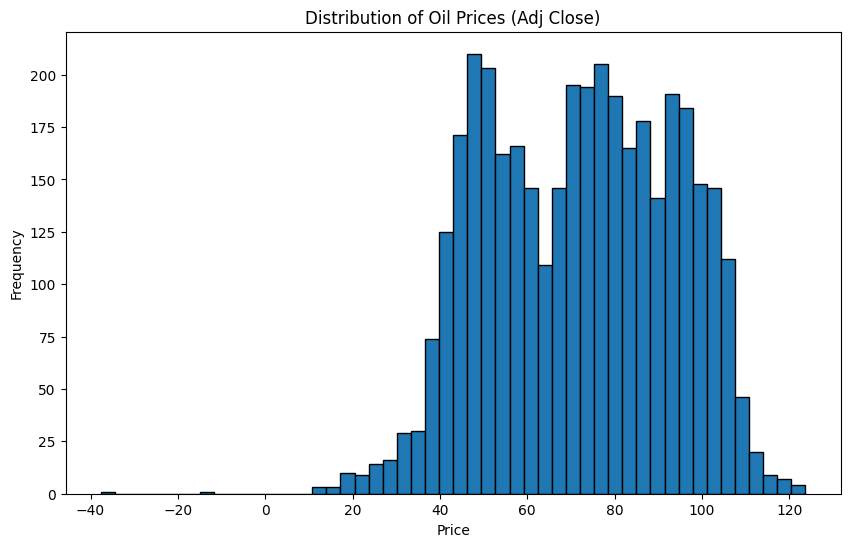


Data split:
Training set size: 2634
Testing set size: 1129


In [22]:
# 2.1 Introduce an additional 10% random missing values into the existing data
non_null_indices = data.dropna().index
indices_to_nullify = np.random.choice(non_null_indices,
                                      size=int(len(non_null_indices) * 0.1),
                                      replace=False)
data.loc[indices_to_nullify] = np.nan

# 2.2 Handle missing values
# The project requires proposing and implementing methods to fill missing data.
# We choose linear interpolation as a straightforward imputation method.
data_filled = data.interpolate(method='linear', limit_direction='both')

# 2.3 Show histogram of price distribution (similar to the figure in the paper)
plt.figure(figsize=(10, 6))
plt.hist(data_filled['Adj Close'].dropna(), bins=50, edgecolor='black')
plt.title('Distribution of Oil Prices (Adj Close)')
plt.xlabel('Price')
plt.ylabel('Frequency')
plt.show()

# 2.4 Normalize the data
scaler = MinMaxScaler()
data_normalized = pd.DataFrame(
    scaler.fit_transform(data_filled),
    columns=data_filled.columns,
    index=data_filled.index
)

# 2.5 Split data into training (70%) and testing (30%)
train_size = int(len(data_normalized) * 0.7)
train_data = data_normalized.iloc[:train_size]
test_data = data_normalized.iloc[train_size:]

print("\nData split:")
print(f"Training set size: {len(train_data)}")
print(f"Testing set size: {len(test_data)}")

# STEP 3: PREPARE DATA FOR DEEP LEARNING MODELS (LSTM, GRU, Bi-LSTM)
*italicized text*

In [6]:
# Create sequences of length seq_length
seq_length = 2
def create_sequences(data, seq_length=2):
    X, y = [], []
    for i in range(len(data) - seq_length):
        X.append(data[i:i+seq_length])
        y.append(data[i+seq_length])
    return np.array(X), np.array(y)

X_train, y_train = create_sequences(train_data.values, seq_length)
X_test, y_test = create_sequences(test_data.values, seq_length)

# Reshape input for neural networks (LSTM/GRU/Bi-LSTM require 3D input: [samples, timesteps, features])
X_train = X_train.reshape((X_train.shape[0], X_train.shape[1], 1))
X_test = X_test.reshape((X_test.shape[0], X_test.shape[1], 1))

In [ ]:
# Hyperparameters from Table 4:
# Learning Rate = 0.001, Batch Size = 100, Epochs = 50, Units = 512 (LSTM/GRU), 1024 (Bi-LSTM), Optimizer = Adam
from tensorflow.keras.callbacks import EarlyStopping

def create_lstm_model():
    model = Sequential([
        LSTM(512, input_shape=(seq_length, 1)),
        Dense(1)
    ])
    model.compile(optimizer=Adam(learning_rate=0.001), loss='mse')
    return model

def create_gru_model():
    model = Sequential([
        GRU(512, input_shape=(seq_length, 1)),
        Dense(1)
    ])
    model.compile(optimizer=Adam(learning_rate=0.001), loss='mse')
    return model

def create_bilstm_model():
    # Bi-LSTM: According to the paper, units=1024 means total.
    model = Sequential([
        Bidirectional(LSTM(512, input_shape=(seq_length, 1))),
        Dense(1)
    ])
    model.compile(optimizer=Adam(learning_rate=0.001), loss='mse')
    return model


# STEP 4: MODEL DEFINITIONS (LSTM, GRU, Bi-LSTM) WITH SPECIFIED HYPERPARAMETERS


# STEP 5: TRAIN THE MODELS


In [ ]:
# We use EarlyStopping to avoid overfitting. Although not required, it ensures stability.
# The instructions do not forbid it, but mention assumptions in final report.
# early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)

def train_model(model_fn, X_train, y_train):
    model = model_fn()
    history = model.fit(
        X_train, y_train,
        epochs=50,
        batch_size=100,
        validation_split=0.2,  # 20% for validation
        # callbacks=[early_stopping],
        verbose=1
    )
    return model, history

models = {
    'LSTM': create_lstm_model,
    'GRU': create_gru_model,
    'Bi-LSTM': create_bilstm_model
}

trained_models = {}
histories = {}

# for model_name, model_fn in models.items():
#     print(f"\nTraining {model_name}...")
#     trained_models[model_name], history = train_model(model_fn, X_train, y_train)
#     histories[model_name] = history

In [ ]:
  print(f"\nTraining LSTM...")
  trained_models["LSTM"], history = train_model(create_lstm_model, X_train, y_train)
  histories["LSTM"] = history


Training LSTM...


/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Epoch 1/50
22/22 ━━━━━━━━━━━━━━━━━━━━ 3s 75ms/step - loss: 0.2657 - val_loss: 0.0374
Epoch 2/50
22/22 ━━━━━━━━━━━━━━━━━━━━ 2s 73ms/step - loss: 0.0125 - val_loss: 0.0027
Epoch 3/50
22/22 ━━━━━━━━━━━━━━━━━━━━ 2s 100ms/step - loss: 0.0023 - val_loss: 0.0015
Epoch 4/50
22/22 ━━━━━━━━━━━━━━━━━━━━ 3s 112ms/step - loss: 0.0016 - val_loss: 0.0017
Epoch 5/50
22/22 ━━━━━━━━━━━━━━━━━━━━ 5s 104ms/step - loss: 0.0012 - val_loss: 0.0015
Epoch 6/50
22/22 ━━━━━━━━━━━━━━━━━━━━ 2s 94ms/step - loss: 9.3875e-04 - val_loss: 0.0012
Epoch 7/50
22/22 ━━━━━━━━━━━━━━━━━━━━ 3s 121ms/step - loss: 6.9071e-04 - val_loss: 9.3343e-04
Epoch 8/50
22/22 ━━━━━━━━━━━━━━━━━━━━ 5s 119ms/step - loss: 4.9225e-04 - val_loss: 7.6591e-04
Epoch 9/50
22/22 ━━━━━━━━━━━━━━━━━━━━ 5s 116ms/step - loss: 3.4454e-04 - val_loss: 6.5483e-04
Epoch 10/50
22/22 ━━━━━━━━━━━━━━━━━━━━ 4s 66ms/step - loss: 2.4358e-04 - val_loss: 5.7623e-04
Epoch 11/50
22/22 ━━━━━━━━━━━━━━━━━━━━ 3s 87ms/step - loss: 1.7995e-04 - val_loss: 5.2145e-04
Epoch 12/50
2

In [ ]:
  print(f"\nTraining GRU...")
  trained_models["GRU"], history = train_model(create_gru_model, X_train, y_train)
  histories["GRU"] = history


Training GRU...
Epoch 1/50
22/22 ━━━━━━━━━━━━━━━━━━━━ 3s 54ms/step - loss: 0.1944 - val_loss: 0.0020
Epoch 2/50
22/22 ━━━━━━━━━━━━━━━━━━━━ 1s 42ms/step - loss: 0.0091 - val_loss: 0.0046
Epoch 3/50
22/22 ━━━━━━━━━━━━━━━━━━━━ 1s 42ms/step - loss: 0.0017 - val_loss: 0.0024
Epoch 4/50
22/22 ━━━━━━━━━━━━━━━━━━━━ 1s 41ms/step - loss: 9.6580e-04 - val_loss: 0.0013
Epoch 5/50
22/22 ━━━━━━━━━━━━━━━━━━━━ 2s 69ms/step - loss: 6.0020e-04 - val_loss: 8.3562e-04
Epoch 6/50
22/22 ━━━━━━━━━━━━━━━━━━━━ 2s 71ms/step - loss: 3.8041e-04 - val_loss: 6.3375e-04
Epoch 7/50
22/22 ━━━━━━━━━━━━━━━━━━━━ 1s 67ms/step - loss: 2.4191e-04 - val_loss: 5.4416e-04
Epoch 8/50
22/22 ━━━━━━━━━━━━━━━━━━━━ 1s 45ms/step - loss: 1.6497e-04 - val_loss: 4.9730e-04
Epoch 9/50
22/22 ━━━━━━━━━━━━━━━━━━━━ 1s 41ms/step - loss: 1.2751e-04 - val_loss: 4.7135e-04
Epoch 10/50
22/22 ━━━━━━━━━━━━━━━━━━━━ 1s 42ms/step - loss: 1.1148e-04 - val_loss: 4.6119e-04
Epoch 11/50
22/22 ━━━━━━━━━━━━━━━━━━━━ 1s 43ms/step - loss: 1.0586e-04 - val_los

In [ ]:
  print(f"\nTraining Bi-LSTM...")
  trained_models["Bi-LSTM"], history = train_model(create_bilstm_model, X_train, y_train)
  histories["Bi-LSTM"] = history


Training Bi-LSTM...
Epoch 1/50
22/22 ━━━━━━━━━━━━━━━━━━━━ 6s 118ms/step - loss: 0.2168 - val_loss: 0.0059
Epoch 2/50
22/22 ━━━━━━━━━━━━━━━━━━━━ 3s 120ms/step - loss: 0.0050 - val_loss: 0.0059
Epoch 3/50
22/22 ━━━━━━━━━━━━━━━━━━━━ 3s 155ms/step - loss: 0.0022 - val_loss: 0.0016
Epoch 4/50
22/22 ━━━━━━━━━━━━━━━━━━━━ 2s 104ms/step - loss: 9.1246e-04 - val_loss: 0.0011
Epoch 5/50
22/22 ━━━━━━━━━━━━━━━━━━━━ 2s 102ms/step - loss: 6.6113e-04 - val_loss: 8.9842e-04
Epoch 6/50
22/22 ━━━━━━━━━━━━━━━━━━━━ 2s 104ms/step - loss: 4.8297e-04 - val_loss: 7.3200e-04
Epoch 7/50
22/22 ━━━━━━━━━━━━━━━━━━━━ 3s 103ms/step - loss: 3.4153e-04 - val_loss: 6.1188e-04
Epoch 8/50
22/22 ━━━━━━━━━━━━━━━━━━━━ 4s 163ms/step - loss: 2.3866e-04 - val_loss: 5.3161e-04
Epoch 9/50
22/22 ━━━━━━━━━━━━━━━━━━━━ 4s 103ms/step - loss: 1.7049e-04 - val_loss: 4.7660e-04
Epoch 10/50
22/22 ━━━━━━━━━━━━━━━━━━━━ 2s 103ms/step - loss: 1.2888e-04 - val_loss: 4.4000e-04
Epoch 11/50
22/22 ━━━━━━━━━━━━━━━━━━━━ 2s 105ms/step - loss: 1.055

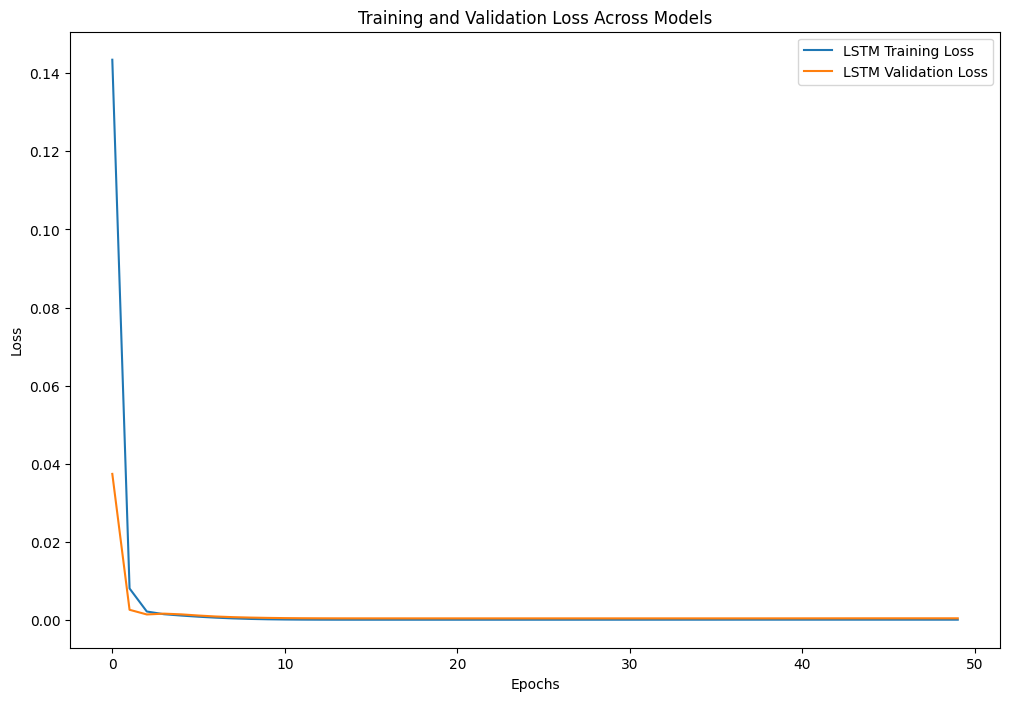

In [ ]:
# Plot training and validation loss
plt.figure(figsize=(12, 8))
model_name, history = "LSTM", histories["LSTM"]
plt.plot(history.history['loss'], label=f'{model_name} Training Loss')
plt.plot(history.history['val_loss'], label=f'{model_name} Validation Loss')

plt.title('Training and Validation Loss Across Models')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

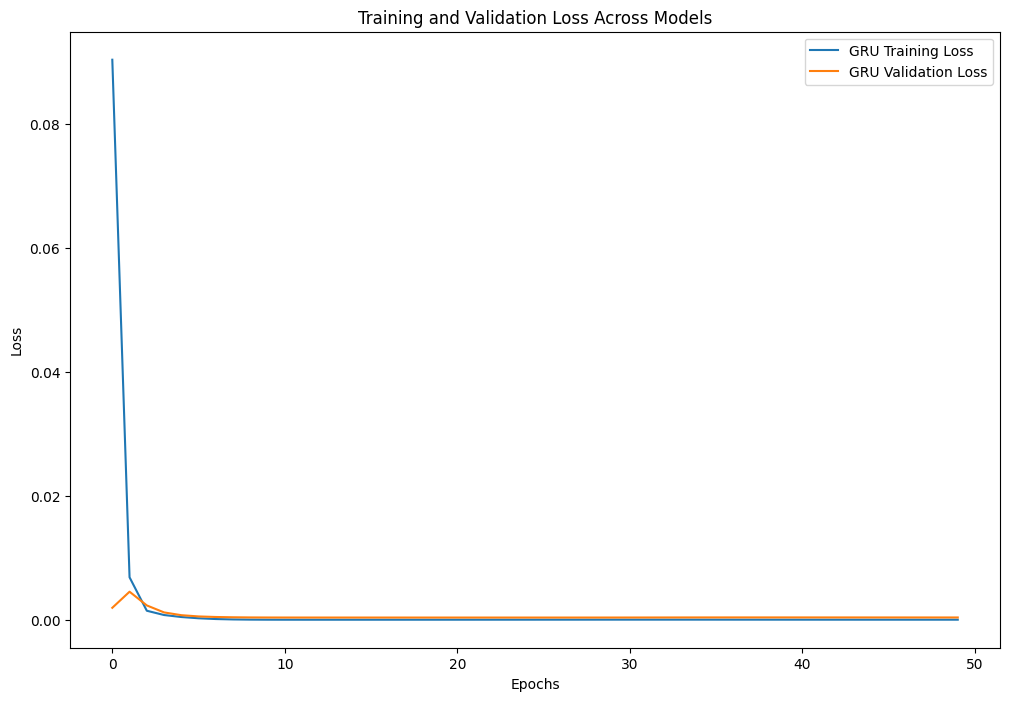

In [ ]:
# Plot training and validation loss
plt.figure(figsize=(12, 8))
model_name, history = "GRU", histories["GRU"]
plt.plot(history.history['loss'], label=f'{model_name} Training Loss')
plt.plot(history.history['val_loss'], label=f'{model_name} Validation Loss')

plt.title('Training and Validation Loss Across Models')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

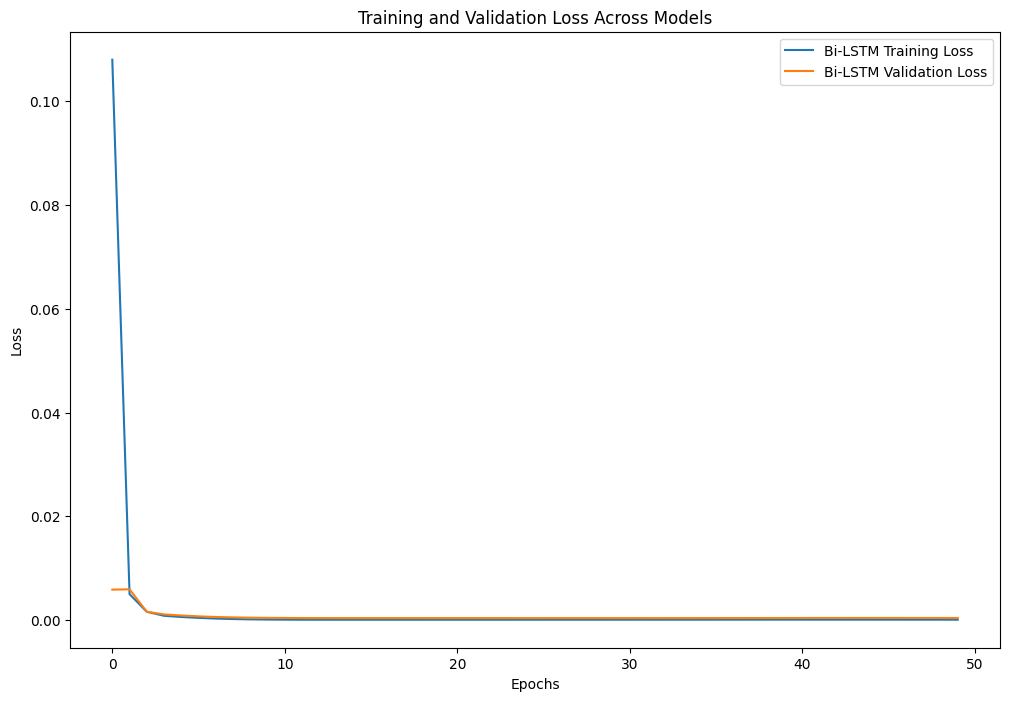

In [ ]:
# Plot training and validation loss
plt.figure(figsize=(12, 8))
model_name, history = "Bi-LSTM", histories["Bi-LSTM"]
plt.plot(history.history['loss'], label=f'{model_name} Training Loss')
plt.plot(history.history['val_loss'], label=f'{model_name} Validation Loss')

plt.title('Training and Validation Loss Across Models')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

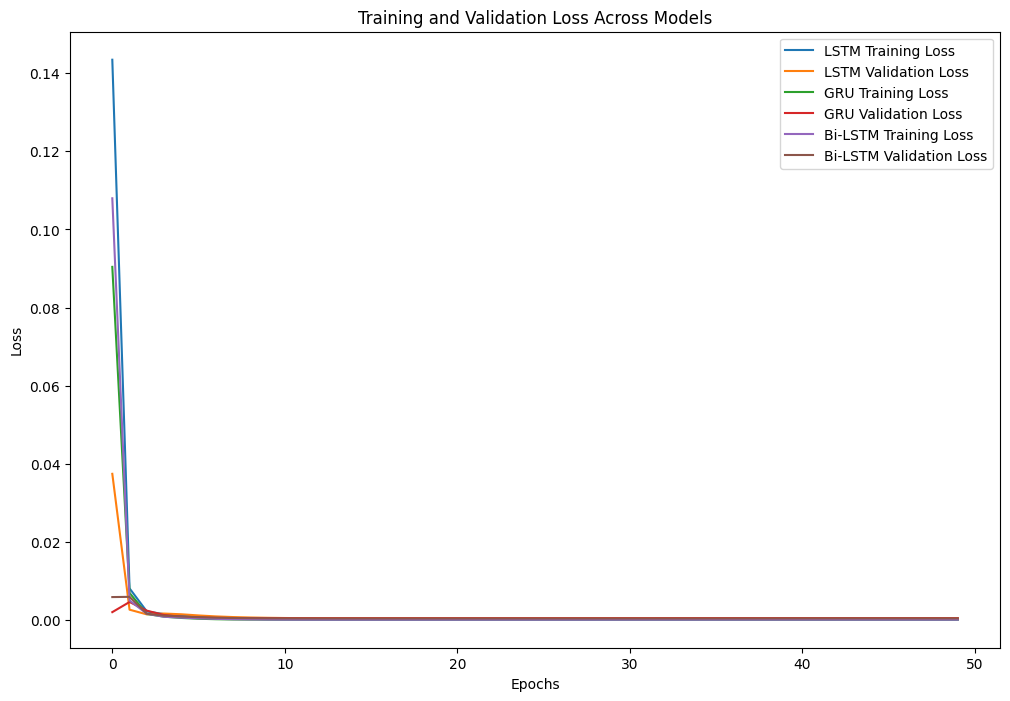

In [ ]:
# Plot training and validation loss
plt.figure(figsize=(12, 8))
for model_name, history in histories.items():
    plt.plot(history.history['loss'], label=f'{model_name} Training Loss')
    plt.plot(history.history['val_loss'], label=f'{model_name} Validation Loss')

plt.title('Training and Validation Loss Across Models')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

# STEP 6: EVALUATE AND COMPARE MODELS (LSTM, GRU, Bi-LSTM)

# Evaluate on the test set, inverse transform predictions and actual values
# We already have evaluate_predictions(actual, predicted) function from above.

In [ ]:
def evaluate_predictions(actual, predicted):
    mae = np.mean(np.abs(predicted - actual))
    mse = np.mean((predicted - actual)**2)
    rmse = np.sqrt(mse)
    r2 = 1 - np.sum((actual - predicted)**2) / np.sum((actual - np.mean(actual))**2)
    mape = np.mean(np.abs((actual - predicted) / actual)) * 100
    return {'MAE': mae, 'MSE': mse, 'RMSE': rmse, 'R2': r2, 'MAPE': mape}

def evaluate_model(model, X, y, scaler):
    predictions = model.predict(X)
    predictions_inv = scaler.inverse_transform(predictions)
    actual_inv = scaler.inverse_transform(y.reshape(-1, 1))
    metrics = evaluate_predictions(actual_inv, predictions_inv)
    return metrics, predictions_inv, actual_inv

results = {}
predictions_dict = {}
if not trained_models:
    print("No models available to evaluate. Please train or save models first.")
else:
    results = {}
    predictions_dict = {}
    for model_name, model in trained_models.items():
        print(f"\nEvaluating {model_name}...")
        metrics, preds_inv, actual_inv = evaluate_model(model, X_test, y_test, scaler)
        results[model_name] = metrics
        predictions_dict[model_name] = preds_inv
        for k, v in metrics.items():
            print(f"{k}: {v:.4f}")


Evaluating LSTM...
36/36 ━━━━━━━━━━━━━━━━━━━━ 2s 32ms/step
MAE: 1.7311
MSE: 6.0458
RMSE: 2.4588
R2: 0.9791
MAPE: 2.2811

Evaluating GRU...
36/36 ━━━━━━━━━━━━━━━━━━━━ 2s 44ms/step
MAE: 1.6794
MSE: 5.6666
RMSE: 2.3805
R2: 0.9804
MAPE: 2.2046

Evaluating Bi-LSTM...
36/36 ━━━━━━━━━━━━━━━━━━━━ 3s 75ms/step
MAE: 1.5538
MSE: 4.8495
RMSE: 2.2022
R2: 0.9832
MAPE: 2.0525


# STEP 7: PLOT PREDICTED VS ACTUAL FOR EACH MODEL


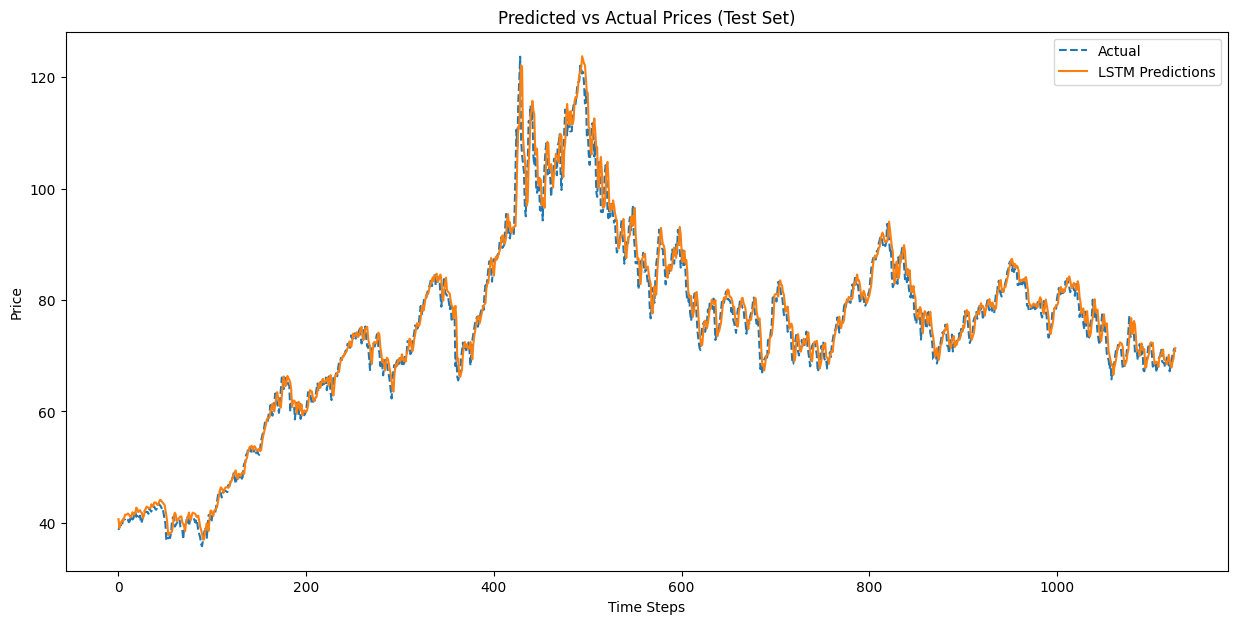

In [ ]:
plt.figure(figsize=(15, 7))
plt.plot(actual_inv, label='Actual', linestyle='--')
model_name, preds = "LSTM", predictions_dict["LSTM"]
plt.plot(preds, label=f'{model_name} Predictions')
plt.title('Predicted vs Actual Prices (Test Set)')
plt.xlabel('Time Steps')
plt.ylabel('Price')
plt.legend()
plt.show()

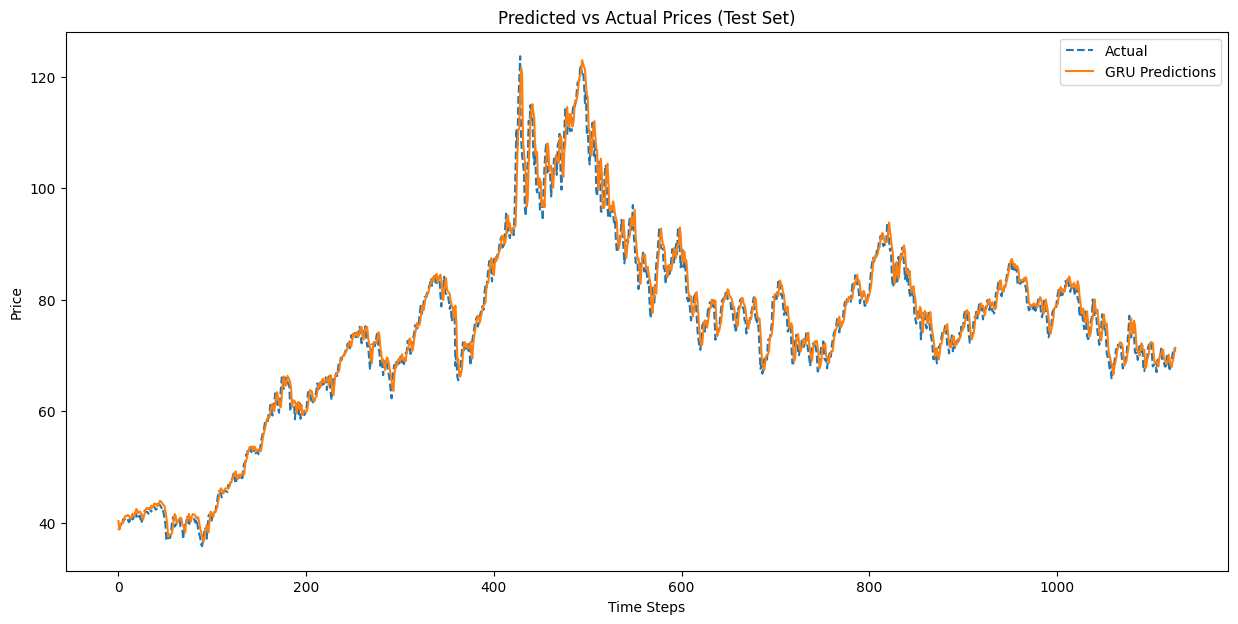

In [ ]:
plt.figure(figsize=(15, 7))
plt.plot(actual_inv, label='Actual', linestyle='--')
model_name, preds = "GRU", predictions_dict["GRU"]
plt.plot(preds, label=f'{model_name} Predictions')
plt.title('Predicted vs Actual Prices (Test Set)')
plt.xlabel('Time Steps')
plt.ylabel('Price')
plt.legend()
plt.show()

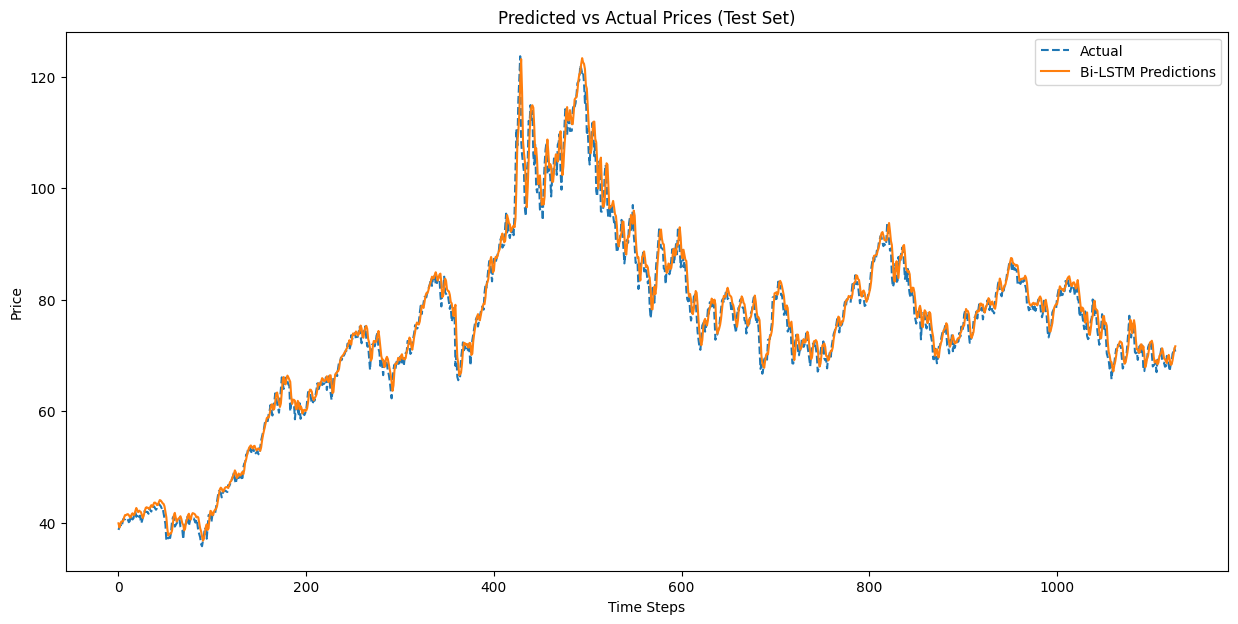

In [ ]:
plt.figure(figsize=(15, 7))
plt.plot(actual_inv, label='Actual', linestyle='--')
model_name, preds = "Bi-LSTM", predictions_dict["Bi-LSTM"]
plt.plot(preds, label=f'{model_name} Predictions')
plt.title('Predicted vs Actual Prices (Test Set)')
plt.xlabel('Time Steps')
plt.ylabel('Price')
plt.legend()
plt.show()

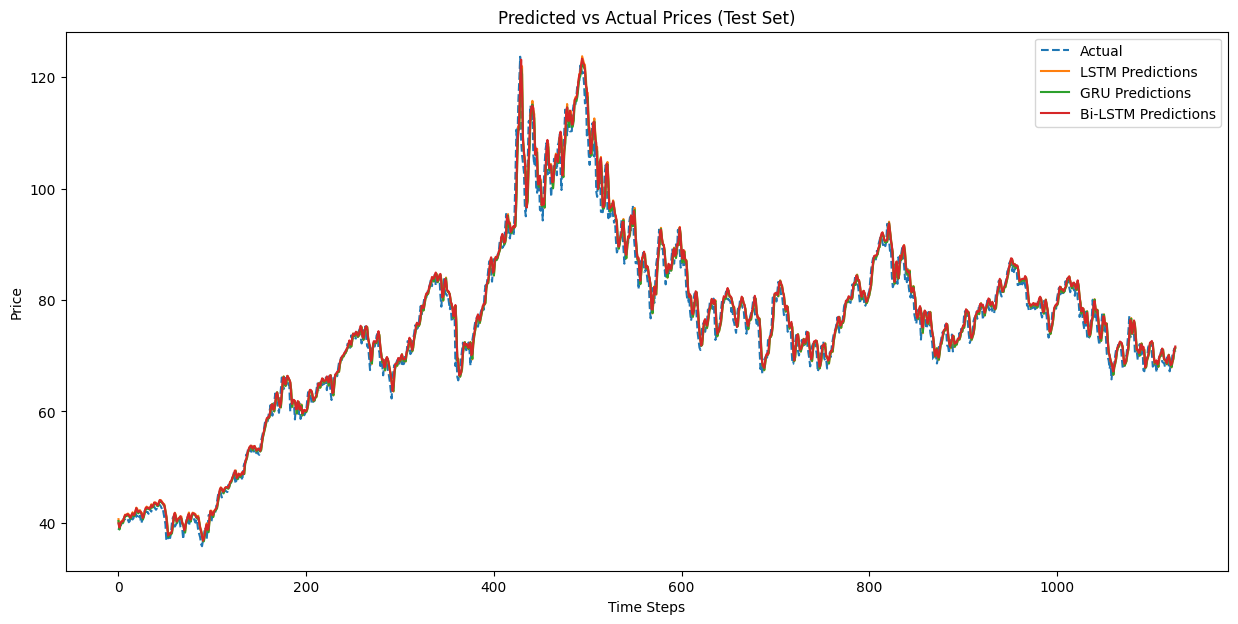

In [ ]:
plt.figure(figsize=(15, 7))
plt.plot(actual_inv, label='Actual', linestyle='--')
for model_name, preds in predictions_dict.items():
    plt.plot(preds, label=f'{model_name} Predictions')
plt.title('Predicted vs Actual Prices (Test Set)')
plt.xlabel('Time Steps')
plt.ylabel('Price')
plt.legend()
plt.show()


In [ ]:
all_results = {
    'LSTM': results['LSTM'],
    'GRU': results['GRU'],
    'Bi-LSTM': results['Bi-LSTM']
}

comparison_df = pd.DataFrame(all_results)
print("\nComparison of Models:")
print(comparison_df)


Comparison of Models:
          LSTM       GRU   Bi-LSTM
MAE   1.731071  1.679370  1.553836
MSE   6.045829  5.666610  4.849487
RMSE  2.458827  2.380464  2.202155
R2    0.979058  0.980371  0.983202
MAPE  2.281083  2.204589  2.052473
